# Run this once in google colab

In [1]:
!git clone -b implementing-vars https://github.com/DrYogurt/Aero-Design-Team-Gamma.git
!pip install poetry==1.4.2

Cloning into 'Aero-Design-Team-Gamma'...
remote: Enumerating objects: 259, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 259 (delta 3), reused 1 (delta 1), pack-reused 254 (from 1)
Receiving objects: 100% (259/259), 41.47 MiB | 7.88 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Updating files: 100% (36/36), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of poetry-plugin-export to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of virtualenv to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of virtualenv to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the depend

In [1]:
%cd Aero-Design-Team-Gamma
!poetry config virtualenvs.in-project true
!poetry install --no-ansi

/content/Aero-Design-Team-Gamma
Creating virtualenv aerospace-design-team-gamma in /content/Aero-Design-Team-Gamma/.venv
Installing dependencies from lock file
The lock file might not be compatible with the current version of Poetry.
Upgrade Poetry to ensure the lock file is read properly or, alternatively, regenerate the lock file with the `poetry lock` command.

Package operations: 134 installs, 1 update, 0 removals

  • Installing attrs (25.1.0)
  • Installing rpds-py (0.22.3)
  • Installing typing-extensions (4.12.2)
  • Installing referencing (0.36.2)
  • Installing six (1.17.0)
  • Installing jsonschema-specifications (2024.10.1)
  • Installing platformdirs (4.3.6)
  • Installing traitlets (5.14.3)
  • Installing python-dateutil (2.9.0.post0)
  • Installing types-python-dateutil (2.9.0.20241206)
  • Installing arrow (1.3.0)
  • Installing fastjsonschema (2.21.1)
  • Installing jsonschema (4.23.0)
  • Installing jupyter-core (5.7.2)
  • Installing pycparser (2.22)
  • Installing p

In [2]:
VENV_PATH = "/content/Aero-Design-Team-Gamma/.venv/lib/python3.11/site-packages"
import os, sys
LOCAL_VENV_PATH = '/content/venv' # local notebook
os.symlink(VENV_PATH, LOCAL_VENV_PATH) # connect to directory in drive
sys.path.insert(0, LOCAL_VENV_PATH)

# Code Begins Here

In [3]:
from ambiance import Atmosphere

from global_variables.solver import EquationSystem
from global_variables.registry import VariableRegistry, Variable

registry = VariableRegistry("aero_vars.yaml")

In [4]:
outputs = {"S_TO", "R", "sigma_max"}
#outputs = {"R", "sigma_max"}

# Create solvers for each output
solvers = {
    output: EquationSystem(registry, {output})
    for output in outputs
}

# Get all unique inputs
all_inputs = set().union(*(solver.inputs for solver in solvers.values()))
print(f"Required inputs: {all_inputs}")
solvers

Required inputs: {'mu', 'W_max', 'e', 'C_Lmax', 'C_D0', 'TSFC', 'S_', 'T_A0', 'rho', 'b', 'V', 'W_pax', 'We_Wmax', 'n_pax'}


{'sigma_max': <global_variables.solver.EquationSystem at 0x7db6987abd10>,
 'S_TO': <global_variables.solver.EquationSystem at 0x7db697dad1d0>,
 'R': <global_variables.solver.EquationSystem at 0x7db697a91390>}

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import sympy

In [13]:
functions, _ = solvers["R"].create_solver()

R_func = functions["R"]

<function _lambdifygenerated(C_D0, S_, TSFC, V, W_max, W_pax, We_Wmax, b, e, n_pax, rho)>

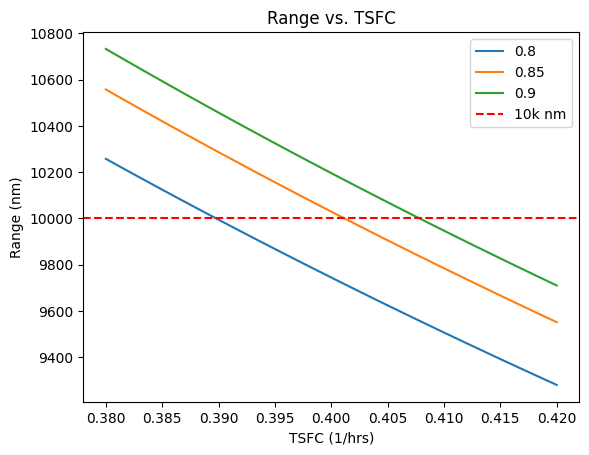

In [24]:
def R_vs_TSFC(cT,M):
  return R_func(C_D0=0.025,
         S_=10200,
         TSFC=cT/3600,
         V=velocity(M=M,h=3.5e4),
         W_max=2e6,
         W_pax=205,
         We_Wmax=.46,
         b=315,
         e=0.9,
         n_pax=1255,
         rho=rho_func(3.5e4))

cTs = np.linspace(0.38,0.42,100)
Rs = {M : R_vs_TSFC(cTs,M) for M in [0.8,0.85,0.9]}

for M,R in Rs.items():
  plt.plot(cTs,R/6017,label=M)
plt.xlabel("TSFC (1/hrs)")
plt.ylabel("Range (nm)")
plt.title("Range vs. TSFC")
# horizontal line at 10k
plt.axhline(y=10e3, color='r', linestyle='--',label="10k nm")
plt.legend()


plt.show()

In [14]:
def velocity(M,h):
  atmo = Atmosphere(h * 0.3048)
  return atmo.speed_of_sound[-1] * M / 0.3048

In [15]:
def rho_func(h):
  atmo = Atmosphere(h * 0.3048)
  return atmo.density[-1] * 0.00194032

In [ ]:

# Generate sample points for each input
n_samples = int(1e3)
samples = {}

# Define ranges for each input (you'll need to adjust these)
ranges = {
    'V':(mach(0.8,35e3),mach(0.95,35e3)), #cruising velocity ft / s
    'S_': (8e3,15e3), # area in ft^2
    'b': (300, 350),  # wingspan in ft^2
    'T_A0': (4.8e5,5.2e5),
    'W_pax': (200,225), #weight per passenger in lbs
    'e':(0.8,1.), # oswald efficiency
    'mu':(.01,.05),
    'W_max':(1.9e6, 2.2e6),  # weight in lbs
    'C_Lmax':(1.5,1.8),  # weight in lbs
    'C_D0':(0.01,0.035),
    'rho':(rho_func(45e3),rho_func(0)),
    'n_pax': (1200,1260), # number of passengers
    'We_Wmax':(0.4,0.6),
    #'h': (0, 40000),  # altitude in ft
    'TSFC': (0.3/3600.,0.6/ 3600), # TSFC

    # Add other inputs and their ranges
}
print(ranges)

{'V': (778.514759070209, 924.4862763958732), 'S_': (8000.0, 15000.0), 'b': (300, 350), 'T_A0': (480000.0, 520000.0), 'W_pax': (200, 225), 'e': (0.8, 1.0), 'mu': (0.01, 0.05), 'W_max': (1900000.0, 2200000.0), 'C_Lmax': (1.5, 1.8), 'C_D0': (0.01, 0.035), 'rho': (0.0004622719956876411, 0.0023768920351669182), 'n_pax': (1200, 1260), 'We_Wmax': (0.4, 0.6), 'TSFC': (8.333333333333333e-05, 0.00016666666666666666)}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Generate Latin Hypercube samples
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=len(all_inputs))
sample_points = sampler.random(n=n_samples)

# Scale samples to actual ranges
input_list = sorted(all_inputs)
for i, input_var in enumerate(input_list):
    if input_var in ranges:
        min_val, max_val = ranges[input_var]
        samples[input_var] = qmc.scale(sample_points[:, [i]], [min_val], [max_val]).flatten()
    else:
        print(f"Warning: No range defined for {input_var}")
        samples[input_var] = sample_points[:, i]  # Use 0-1 range as default

In [ ]:
# Calculate outputs
results = {}
for output, solver in solvers.items():
    solver_f,_ = solver.create_solver()
    solver_func = solver_f[output]
    input_args = [samples[inp] for inp in sorted(solver.inputs)]
    try:
        output_values = np.array(solver_func(*input_args))
        print(output_values)
        # Ensure output is 1D array of correct length
        if output_values.size == 1:
            output_values = np.full(n_samples, output_values)
        results[output] = output_values
    except Exception as e:
        print(f"Error calculating {output}: {e}")
#results

[48106.78743448 23977.00034352 19946.57708449 ... 16023.01719092
 17322.89024728 24330.93880292]
[43511957.17625377 37797936.02681816 44923105.02709642 ...
 31927327.05539108 42168514.62117565 89299012.64495397]
[0.2487503  0.31594882 0.1997739  ... 0.2201643  0.24236133 0.159023  ]


In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata


def create_output_corner_plot(samples, output_values, setpoint, output_name,
                            figsize=(10, 10), n_contours=20, n_grid=50):
    """
    Create a corner plot with contours showing how output varies with input pairs.
    """
    # Print value ranges for debugging
    print(f"Output range: {np.min(output_values):.2f} to {np.max(output_values):.2f}")
    print(f"Setpoint: {setpoint}")

    # Create diverging colormap centered at setpoint
    colors = ['darkred', 'red', 'lightcoral', 'white', 'lightgreen', 'green', 'darkgreen']
    custom_cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)

    input_vars = list(samples.keys())
    n_vars = len(input_vars)

    # Create figure with small margins
    fig, axes = plt.subplots(n_vars, n_vars, figsize=figsize)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # If only one variable, axes won't be a 2D array
    if n_vars == 1:
        axes = np.array([[axes]])

    # Calculate differences and normalize
    differences = output_values - setpoint
    abs_max = max(abs(np.min(differences)), abs(np.max(differences)))

    # Create levels based on percentage differences from setpoint
    rel_diffs = differences / abs(setpoint) * 100  # Convert to percentage
    max_rel_diff = max(abs(np.min(rel_diffs)), abs(np.max(rel_diffs)))

    # Create symmetric levels around zero in percentage terms
    level_step = max_rel_diff / (n_contours // 2)
    levels = np.concatenate([
        np.arange(-max_rel_diff, 0, level_step),
        np.array([0]),
        np.arange(level_step, max_rel_diff + level_step, level_step)
    ])

    # Create the corner plot
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]

            # Remove top and right spines for all plots
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            if i < j:  # Upper triangle - leave empty
                ax.axis('off')
                continue

            elif i == j:  # Diagonal - histogram
                ax.hist(samples[input_vars[i]], bins=30, density=True)
                if i == n_vars-1:  # Only bottom row gets x labels
                    ax.set_xlabel(input_vars[i])
                else:
                    ax.set_xticklabels([])

                if j == 0:  # Only first column gets y labels
                    ax.set_ylabel('Density')
                else:
                    ax.set_yticklabels([])

            else:  # Lower triangle - contour plots
                x = samples[input_vars[j]]
                y = samples[input_vars[i]]

                # Create grid for contour plot
                xi = np.linspace(x.min(), x.max(), n_grid)
                yi = np.linspace(y.min(), y.max(), n_grid)
                xi, yi = np.meshgrid(xi, yi)

                # Interpolate relative differences on the grid
                zi = griddata((x, y), rel_diffs, (xi, yi), method='cubic')

                # Create contour plot
                contour = ax.contourf(xi, yi, zi, levels=levels, cmap=custom_cmap, extend='both')

                # Add colorbar only for rightmost plots
                if j == n_vars-1:
                    cbar = plt.colorbar(contour, ax=ax, ticks=levels[::2])
                    cbar.set_label('% Difference from setpoint')

                # Add setpoint contour in black
                ax.contour(xi, yi, zi, levels=[0], colors='black', linestyles='dashed')

                # Only add x labels to bottom row
                if i == n_vars-1:
                    ax.set_xlabel(input_vars[j])
                else:
                    ax.set_xticklabels([])

                # Only add y labels to leftmost column
                if j == 0:
                    ax.set_ylabel(input_vars[i])
                else:
                    ax.set_yticklabels([])

    plt.suptitle(f'Parameter Effects on {output_name} (Setpoint: {setpoint})', y=1.02)
    return fig, axes

In [ ]:
setpoints={'R':1e4*6076,'sigma_max':0.247,'S_TO':1e4}
for output in solvers.keys():
    fig, axes = create_output_corner_plot(samples,results[output],output_name = output, setpoint=setpoints[output],
                                         figsize=(30,30))
    # Add title
    #fig.suptitle(f"Corner Plots for {output}", fontsize=14, y=1.02)

    # Save figure
    plt.savefig(f"corner_plot_{output}.png", dpi=300)
    plt.close()

Output range: 5871.97 to 83435.64
Setpoint: 10000.0
Output range: 6703085.48 to 185389375.60
Setpoint: 60760000.0
Output range: 0.11 to 0.41
Setpoint: 0.247
